<a href="https://colab.research.google.com/github/MainN/diploma/blob/master/Pystan_measles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
!pip install pystan
!pip install stan_utility
!pip install arviz

     |████████████████████████████████| 1.6MB 4.0MB/s 
     |████████████████████████████████| 4.7MB 20.1MB/s 
     |████████████████████████████████| 768kB 51.1MB/s 
     |████████████████████████████████| 317kB 48.4MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [130]:
import os
import pystan
import seaborn as sns
import pandas as pd
from math import exp, cos, pi, log
import stan_utility
import numpy as np
import arviz

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
My_data=pd.read_csv("/content/gdrive/My Drive/data.csv")
My_data=My_data.fillna(0)
My_data


,t5,t6,t9,t12,t15,t20
0,386.0,249.0,108.0,66.0,67.0,59.0
1,281.0,229.0,39.0,38.0,0.0,18.0
2,0.0,115.0,0.0,0.0,0.0,28.0
3,122.0,0.0,105.0,21.0,34.0,32.0
4,868.0,482.0,370.0,0.0,98.0,72.0
...,...,...,...,...,...,...
159,463.0,254.0,0.0,97.0,0.0,47.0
160,478.0,93.0,0.0,38.0,23.0,20.0
161,0.0,402.0,0.0,0.0,26.0,20.0
162,159.0,100.0,48.0,31.0,14.0,12.0


In [80]:
code ='''
data {
    int  T ;  // Time
    int  N ;  // number of individuals
    real time[T]; // time measurements
    real dset[N,T]; // data
    
 }
parameters {
    real b0;
    real b1;
    vector[N] C;
    real<lower = 0> delta_C;
    real<lower = 0> delta_ERR;
}
model {
    delta_ERR ~ exponential(1);
    delta_C ~ exponential(1);
    b0 ~ normal(0,1);
    b1 ~ normal(0,1);
    C ~ normal(0,delta_C);
    for (t in 1:T) {
        for (i in 1:N) {
            if (dset[i,t] != 0)  {dset[i,t] ~ normal(C[i] + b0 + b1 * time[t],delta_ERR);}
        }
    }
}
'''
sm = pystan.StanModel(model_code=code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe15037ebbe0e7dfad1b1a69aea68d55 NOW.


In [134]:
T=1#6
time =[log(x) for x in [1]]#[log(x) for x in [1,2,5,8,11,16]]
N = 1#len(My_data)
data  = dict(
        T=T,
        N=N,
        dset=[[My_data.values[1,1]]],
        time=time)
init = dict(
    b0 = 6,
    b1 = -2,
    C = [0]*N,
    delta_C=1,
    delta_ERR=1)  


In [135]:
fit = sm.sampling(data=data, iter=10000, chains=4, init=[init]*4,thin=1,control={'max_treedepth': 20})
op = fit.extract()  

In [136]:
print(fit)

Inference for Stan model: anon_model_fe15037ebbe0e7dfad1b1a69aea68d55.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
b0           0.2    0.02   1.01  -1.74  -0.48    0.19   0.87   2.19   1786    1.0
b1         -0.01    0.02   0.99   -2.0  -0.65 -8.9e-3   0.64   1.89   3949    1.0
C[1]         0.4    0.03   1.84  -2.27  -0.28    0.09   0.71   4.82   3755    1.0
delta_C     1.16    0.02    1.1   0.15   0.39    0.81   1.57   4.13   2489    1.0
delta_ERR  37.56    0.06   3.55  31.14  35.08   37.33   39.8  45.09   3047    1.0
lp__      -59.24    0.04   1.77 -63.55 -60.21  -58.94 -57.92 -56.78   1920    1.0

Samples were drawn using NUTS at Mon Apr 19 13:33:26 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [122]:
print(op.keys())
print(len(op['b0']))

odict_keys(['b0', 'b1', 'C', 'delta_C', 'delta_ERR', 'lp__'])
20000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb96d4bb150>,
      dtype=object)

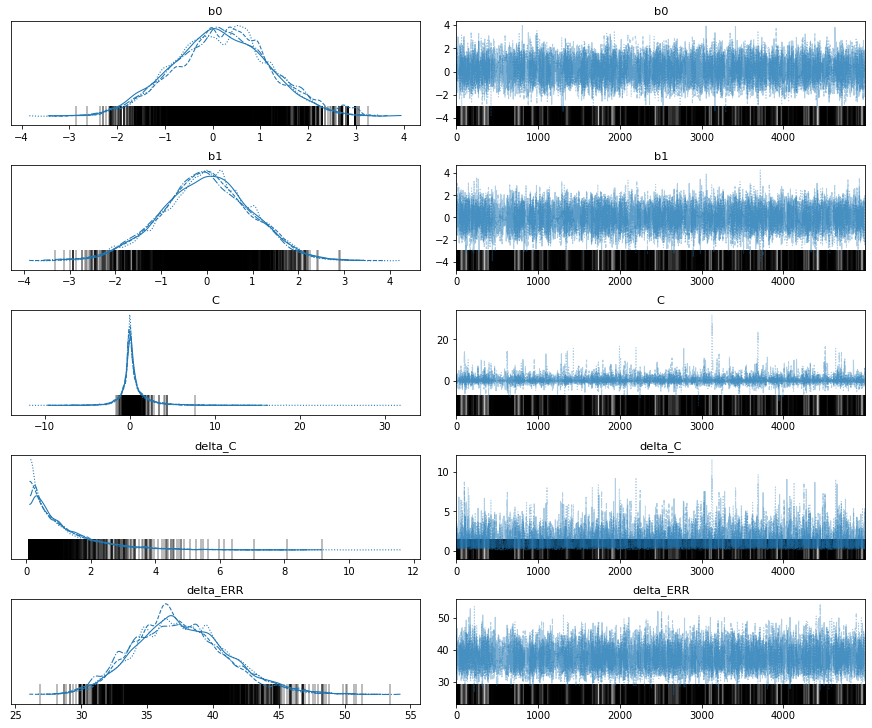

In [137]:
arviz.plot_trace(fit)

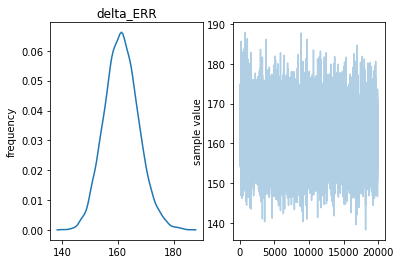

In [123]:
fit.plot('delta_ERR');

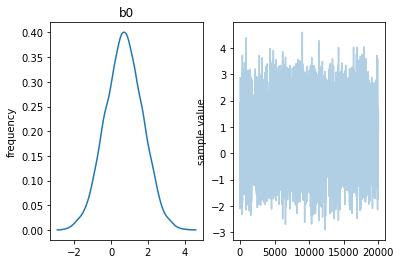

In [124]:
fit.plot('b0');

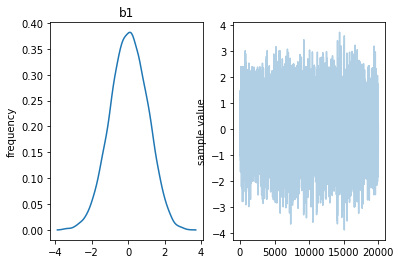

In [125]:
fit.plot('b1');

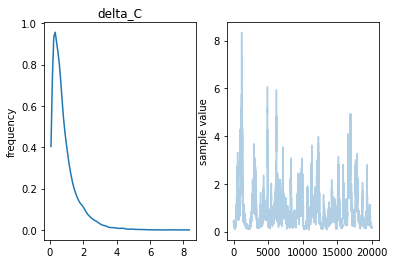

In [126]:
fit.plot('delta_C');

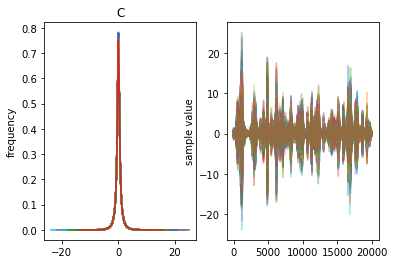

In [127]:
fit.plot('C');